In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from hpelm import ELM
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df1 = pd.read_csv('Jan_2019_ontime.csv')
df2 = pd.read_csv('Jan_2020_ontime.csv')

# Add 'year' column to df1 and df2
df1 = df1.assign(year=0)
df2 = df2.assign(year=1)

# Concatenate the two DataFrames
df = pd.concat([df1, df2], ignore_index=True)

df = df.drop("Unnamed: 21", axis=1)

# Display the merged DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df.shape[0])
df.head()

1191331


,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,year
0,11,6,YV,20378,YV,N918FJ,5959,10279,1027903,AMA,...,DFW,1613.0,0.0,1600-1659,1727.0,0.0,0.0,0.0,312.0,1
1,27,7,MQ,20398,MQ,N242NN,3777,12945,1294503,LEX,...,DFW,1628.0,0.0,1600-1659,1758.0,0.0,0.0,0.0,785.0,0
2,11,6,9E,20363,9E,N295PQ,5225,11193,1119302,CVG,...,JFK,1753.0,0.0,1800-1859,1955.0,0.0,0.0,0.0,589.0,1
3,16,4,DL,19790,DL,N925DZ,845,10397,1039707,ATL,...,PBI,934.0,0.0,0900-0959,1114.0,0.0,0.0,0.0,545.0,1
4,22,3,MQ,20398,MQ,N675AE,4182,11298,1129806,DFW,...,SGF,857.0,1.0,0800-0859,1021.0,1.0,0.0,0.0,364.0,1


In [5]:
percentage_null = (df.isnull().sum().sum() / df.size) * 100

print(f"Percentage of null values in the DataFrame: {percentage_null:.2f}%")
print(df.isnull().sum())

Percentage of null values in the DataFrame: 0.38%
DAY_OF_MONTH                 0
DAY_OF_WEEK                  0
OP_UNIQUE_CARRIER            0
OP_CARRIER_AIRLINE_ID        0
OP_CARRIER                   0
TAIL_NUM                  3241
OP_CARRIER_FL_NUM            0
ORIGIN_AIRPORT_ID            0
ORIGIN_AIRPORT_SEQ_ID        0
ORIGIN                       0
DEST_AIRPORT_ID              0
DEST_AIRPORT_SEQ_ID          0
DEST                         0
DEP_TIME                 23016
DEP_DEL15                23054
DEP_TIME_BLK                 0
ARR_TIME                 24136
ARR_DEL15                26100
CANCELLED                    0
DIVERTED                     0
DISTANCE                     0
year                         0
dtype: int64


In [6]:
df = df.dropna()
print("number of rows after deleting the ones with null value: ", df.shape[0])

number of rows after deleting the ones with null value:  1165231


In [7]:
#taget would be and of arrival delay and deprature delay

df['DEP_DEL15'] = df['DEP_DEL15'].astype(int)
df['ARR_DEL15'] = df['ARR_DEL15'].astype(int)

df['DELAY'] = (df['DEP_DEL15'] | df['ARR_DEL15']).astype(int)

# Drop the original columns 'DEP_DEL15' and 'ARR_DEL15'
df.drop(['DEP_DEL15', 'ARR_DEL15'], axis=1, inplace=True)

# Display the DataFrame after the changes
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST_AIRPORT_SEQ_ID,DEST,DEP_TIME,DEP_TIME_BLK,ARR_TIME,CANCELLED,DIVERTED,DISTANCE,year,DELAY
0,11,6,YV,20378,YV,N918FJ,5959,10279,1027903,AMA,...,1129806,DFW,1613.0,1600-1659,1727.0,0.0,0.0,312.0,1,0
1,27,7,MQ,20398,MQ,N242NN,3777,12945,1294503,LEX,...,1129806,DFW,1628.0,1600-1659,1758.0,0.0,0.0,785.0,0,0
2,11,6,9E,20363,9E,N295PQ,5225,11193,1119302,CVG,...,1247805,JFK,1753.0,1800-1859,1955.0,0.0,0.0,589.0,1,0
3,16,4,DL,19790,DL,N925DZ,845,10397,1039707,ATL,...,1402702,PBI,934.0,0900-0959,1114.0,0.0,0.0,545.0,1,0
4,22,3,MQ,20398,MQ,N675AE,4182,11298,1129806,DFW,...,1478302,SGF,857.0,0800-0859,1021.0,0.0,0.0,364.0,1,1


In [8]:
delay_percentage = df['DELAY'].value_counts(normalize=True) * 100

print("Percentage of delay:\n", delay_percentage)

Percentage of delay:
 DELAY
0    80.474687
1    19.525313
Name: proportion, dtype: float64


In [9]:
# Display the number of unique values for each categorical attribute
data_types = df.dtypes
categorical_columns = data_types[data_types == 'object'].index.tolist()
for column in categorical_columns:
    unique_values = df[column].nunique()
    print(f"{column}: {unique_values} unique values")


OP_UNIQUE_CARRIER: 17 unique values
OP_CARRIER: 17 unique values
TAIL_NUM: 5854 unique values
ORIGIN: 353 unique values
DEST: 353 unique values
DEP_TIME_BLK: 19 unique values


In [10]:
columns_to_drop = ['OP_CARRIER_AIRLINE_ID', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID']
df = df.drop(columns=columns_to_drop)


In [11]:
data_types = df.dtypes

# Separate columns into categorical and numerical based on data types
categorical_columns = data_types[data_types == 'object'].index.tolist()
numerical_columns = data_types[data_types != 'object'].index.tolist()

print("Categorical columns:")
print(categorical_columns)

print("\nNumerical columns:")
print(numerical_columns)

Categorical columns:
['OP_UNIQUE_CARRIER', 'OP_CARRIER', 'TAIL_NUM', 'ORIGIN', 'DEST', 'DEP_TIME_BLK']

Numerical columns:
['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER_FL_NUM', 'DEP_TIME', 'ARR_TIME', 'CANCELLED', 'DIVERTED', 'DISTANCE', 'year', 'DELAY']


In [12]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of the original DataFrame to avoid modifying the original data
df_encoded = df.copy()

# Apply Label Encoding to each categorical column
label_encoder = LabelEncoder()
for column in categorical_columns:
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

print(df_encoded.head())


   DAY_OF_MONTH  DAY_OF_WEEK  OP_UNIQUE_CARRIER  OP_CARRIER  TAIL_NUM  \
0            11            6                 15          15      5125   
1            27            7                  9           9       903   
2            11            6                  0           0      1222   
3            16            4                  4           4      5215   
4            22            3                  9           9      3111   

   OP_CARRIER_FL_NUM  ORIGIN  DEST  DEP_TIME  DEP_TIME_BLK  ARR_TIME  \
0               5959      14    91    1613.0            11    1727.0   
1               3777     189    91    1628.0            11    1758.0   
2               5225      82   172    1753.0            13    1955.0   
3                845      19   249     934.0             4    1114.0   
4               4182      91   303     857.0             3    1021.0   

   CANCELLED  DIVERTED  DISTANCE  year  DELAY  
0        0.0       0.0     312.0     1      0  
1        0.0       0.0     785.0

In [13]:
X = df_encoded.drop('DELAY', axis=1)
y = df_encoded['DELAY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [14]:
from sklearn.preprocessing import StandardScaler

scaler_train = StandardScaler()
X_train_normalized = scaler_train.fit_transform(X_train)

scaler_test = StandardScaler()
X_test_normalized = scaler_test.fit_transform(X_test)


MLP:

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp_classifier = MLPClassifier(hidden_layer_sizes=(150,),
                                max_iter=1000,
                                learning_rate='constant',
                                learning_rate_init=0.001,
                                  random_state=42)




mlp_classifier.fit(X_train_normalized, y_train)




MLPClassifier(hidden_layer_sizes=(150,), max_iter=1000, random_state=42)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94    281315
           1       0.90      0.55      0.68     68255

    accuracy                           0.90    349570
   macro avg       0.90      0.77      0.81    349570
weighted avg       0.90      0.90      0.89    349570


Confusion Matrix:
[[277136   4179]
 [ 30725  37530]]


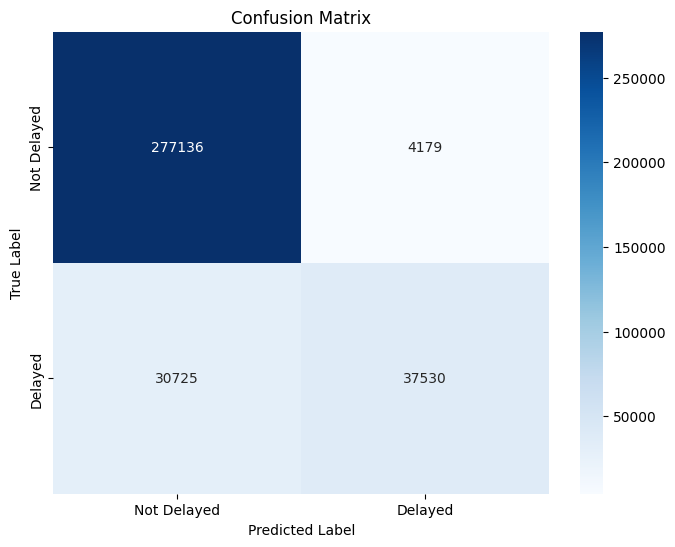

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_mlp = mlp_classifier.predict(X_test_normalized)

classification_rep = classification_report(y_test, y_pred_mlp)
conf_matrix = confusion_matrix(y_test, y_pred_mlp)

print("Classification Report:")
print(classification_rep)

# Display the confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Delayed", "Delayed"],
            yticklabels=["Not Delayed", "Delayed"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

ELM:

In [21]:
import numpy as np

class ELMClassifier:
    def __init__(self, input_size, hidden_size, activation_func='sigmoid'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.activation_func = activation_func
        self.weights_input_hidden = np.random.randn(input_size, hidden_size)
        self.bias_input_hidden = np.random.randn(1, hidden_size)
        self.weights_hidden_output = None
        self.bias_hidden_output = None

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def relu(self, x):
        return np.maximum(0, x)

    def train(self, X, y):
        # Compute hidden layer output
        if self.activation_func == 'sigmoid':
            hidden_output = self.sigmoid(np.dot(X, self.weights_input_hidden) + self.bias_input_hidden)
        elif self.activation_func == 'relu':
            hidden_output = self.relu(np.dot(X, self.weights_input_hidden) + self.bias_input_hidden)
        else:
            raise ValueError("Unsupported activation function")

        # Moore-Penrose pseudo-inverse to compute output weights
        pinv = np.linalg.pinv(hidden_output)
        self.weights_hidden_output = np.dot(pinv, y)
        self.bias_hidden_output = np.zeros((1, y.shape[1]))

    def predict(self, X):
        hidden_output = None

        # Compute hidden layer output
        if self.activation_func == 'sigmoid':
            hidden_output = self.sigmoid(np.dot(X, self.weights_input_hidden) + self.bias_input_hidden)
        elif self.activation_func == 'relu':
            hidden_output = self.relu(np.dot(X, self.weights_input_hidden) + self.bias_input_hidden)
        else:
            raise ValueError("Unsupported activation function")

        # Compute final output
        output = np.dot(hidden_output, self.weights_hidden_output) + self.bias_hidden_output
        return output

input_size = X_train_normalized.shape[1]
hidden_size = 500  

# Oversample the minority class to balance the data
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_normalized, y_train)

# Convert y_resampled to a NumPy array and reshape it
y_resampled = np.array(y_resampled).reshape(-1, 1)

# Create and train ELM model
elm_model = ELMClassifier(input_size, hidden_size, activation_func='sigmoid')
elm_model.train(X_resampled, y_resampled)



Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80    281315
           1       0.36      0.66      0.47     68255

    accuracy                           0.71    349570
   macro avg       0.63      0.69      0.63    349570
weighted avg       0.79      0.71      0.73    349570


Confusion Matrix:
[[202418  78897]
 [ 23505  44750]]

Accuracy: 0.7070629630689133


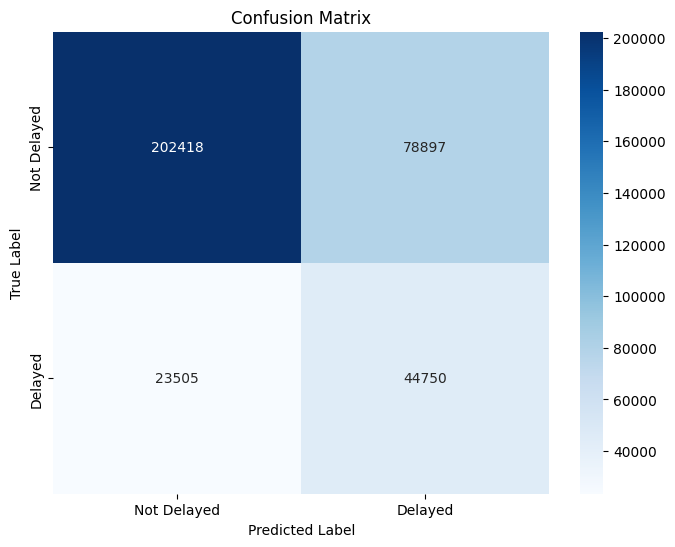

micro accuracy:  0.73


'\ntn = 244466  \nfp = 63181\ntp = 30475\nfn = 11448  \naccuracy_class_0 = tn / (tn + fp)\naccuracy_class_1 = tp / (tp + fn)\nmacro_accuracy = (accuracy_class_0 + accuracy_class_1) / 2\nprint(macro_accuracy)\n'

In [22]:
# Make predictions on the test set
y_pred_elm = elm_model.predict(X_test_normalized)

# Convert predictions to binary labels
threshold = 0.5
y_pred_binary = (y_pred_elm >= threshold).astype(int)

classification_rep = classification_report(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

print("Classification Report:")
print(classification_rep)

print("\nConfusion Matrix:")
print(conf_matrix)

accuracy = accuracy_score(y_test, y_pred_binary)
print("\nAccuracy:", accuracy)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Delayed", "Delayed"],
            yticklabels=["Not Delayed", "Delayed"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

micro_accuracy = float(classification_rep.split()[-2])
print("micro accuracy: ",micro_accuracy)


Auto Encoder:
1- make an encoder to encode X_train
2- using X_train_enoded and y_train i will train an XGBoost model
3- using the encoder i trained, i will encode X_test
4- using the XGBoost model i trained, i will predict y_test with X_test_encoded
5- report accuracy on y_test

In [15]:
# Step 1: Train an Autoencoder and Encode X_train

from sklearn.neural_network import MLPRegressor

autoencoder = MLPRegressor(
    hidden_layer_sizes=(15, 8, 10),  
    max_iter=100,  
    random_state=42
)

autoencoder.fit(X_train, X_train)

# Encode X_train
X_train_encoded = autoencoder.predict(X_train)



c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [20]:
# Step 2: Train an XGBoost Model

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb_model = XGBClassifier(random_state=42)

xgb_model.fit(X_train_encoded, y_train)





XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [21]:
# Step 3: Encode X_test using the previously trained autoencoder


X_test_encoded = autoencoder.predict(X_test)

# Step 4: Predict y_test using the encoded X_test and the XGBoost model

y_pred_xg = xgb_model.predict(X_test_encoded)



Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91    281315
           1       0.86      0.21      0.34     68255

    accuracy                           0.84    349570
   macro avg       0.85      0.60      0.62    349570
weighted avg       0.84      0.84      0.80    349570



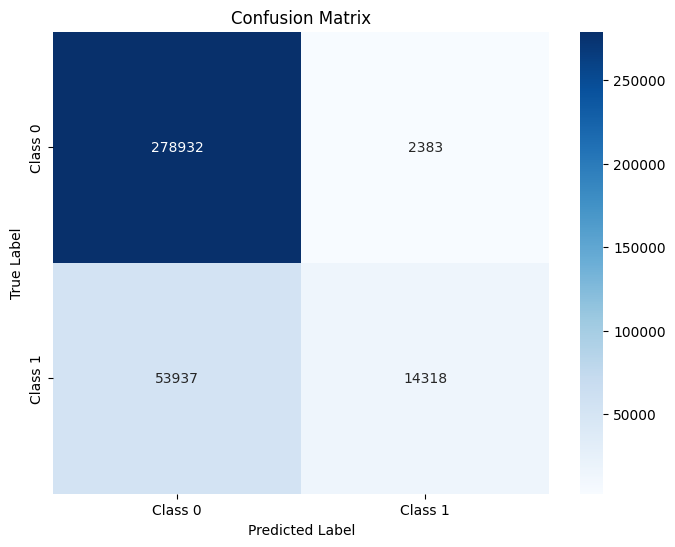

In [22]:
# Step 5: Report Accuracy Measures and Draw Confusion Matrix


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


print("Classification Report:")
print(classification_report(y_test, y_pred_xg))

conf_matrix = confusion_matrix(y_test, y_pred_xg)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
